In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.random import multivariate_normal
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib
from tqdm import tqdm
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

# Question 2.2.1
## Linear SVM for Multivariate Gaussian 
with μ =2.5 and -2.5 and $Ι_{2×2}$ as covariance matrix

In [ ]:
c=0.01
lr=0.1
batchsize=5
epoch=10
device="cuda"
def accPrint(u,testaccuracies):
  fig=plt.figure(figsize=(4,4),dpi=200)
  plt.plot(u,testaccuracies)
  plt.xlabel("Mean")
  plt.ylabel("Test Accuracy percent")
  plt.grid()
  plt.show()

def train(X, Y, X_val, y_val, model):
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    N = len(Y)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    model.train()
    for ep in range(epoch):
        permute = torch.randperm(N)
        sum_loss = 0

        for i in range(0, N, batchsize):
            x = X[permute[i : i + batchsize]].to(device)
            y = Y[permute[i : i + batchsize]].to(device)

            optimizer.zero_grad()
            output = model(x).squeeze()
            weight = model.weight.squeeze()

            loss = torch.mean(torch.clamp(1 - y * output, min=0))
            loss += c * (weight.t() @ weight) / 2.0

            loss.backward()
            optimizer.step()

            sum_loss += float(loss)
        
        print("Epoch: {:4d}\tTraining loss: {}".format(ep+1, sum_loss / N))
        print("Validation accuracy: ",accuracy_score(y_val,predict(X_val,y_val,model)))


def visualize(X, Y, model):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()

    delta = 0.001
    x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
    y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
    x, y = np.meshgrid(x, y)
    xy = list(map(np.ravel, [x, y]))

    z = (W.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.0)] = 4
    z[np.where((z > 0.0) & (z <= 1.0))] = 3
    z[np.where((z > -1.0) & (z <= 0.0))] = 2
    z[np.where(z <= -1.0)] = 1

    plt.figure(figsize=(10, 10))
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.contourf(x, y, z, alpha=0.8, cmap="Blues")
    plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10)
    plt.tight_layout()
    plt.show()

def predict(X, Y, model):
    W = model.weight.squeeze().detach().cpu().numpy()
    b = model.bias.squeeze().detach().cpu().numpy()
    y_test_predicted = np.array([])
    for i in range(X.shape[0]):
      yp = np.sign(np.dot(W, X[i])) #model
      y_test_predicted = np.append(y_test_predicted, yp)
    return y_test_predicted

In [ ]:
def linearSVM(u,plotTrue):
  device="cuda"
  device = torch.device(device if torch.cuda.is_available() else "cpu")
  testaccuracies=[]
  for i in range(len(u)):
    print(u[i])
    u0=np.array([u[i],0]).T
    u1=np.array([-u[i],0]).T

    covar0=[[1,0],[0,1]]
    covar1=[[1,0],[0,1]]

    XP = multivariate_normal(u0,covar0,750)
    XN = multivariate_normal(u1,covar1,750)
    YP = np.ones(750)
    YN = np.empty(750)
    YN.fill(-1)
    X , Y = np.concatenate((XP,XN)),np.hstack((YP,YN))
    X, Y = shuffle(X,Y,random_state=1)

    model = nn.Linear(2, 1)
    model.to(device)


    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

    train(X_train, y_train, X_val, y_val, model)
    score = accuracy_score(y_test,predict(X_test,y_test,model))
    print("Test accuracy: ",score)
    testaccuracies.append(score*100)
    if plotTrue:
        visualize(X, Y, model)
  return testaccuracies
   

2.5
Epoch:    1	Training loss: 0.014071529164211824
Validation accuracy:  0.996
Epoch:    2	Training loss: 0.007414117569103837
Validation accuracy:  0.996
Epoch:    3	Training loss: 0.007470104996114969
Validation accuracy:  0.996
Epoch:    4	Training loss: 0.00745726809091866
Validation accuracy:  0.996
Epoch:    5	Training loss: 0.007443904715590179
Validation accuracy:  0.996
Epoch:    6	Training loss: 0.007459629380144179
Validation accuracy:  0.996
Epoch:    7	Training loss: 0.0074071396626532076
Validation accuracy:  0.996
Epoch:    8	Training loss: 0.007399931528605521
Validation accuracy:  0.996
Epoch:    9	Training loss: 0.007410244611091912
Validation accuracy:  0.996
Epoch:   10	Training loss: 0.007403984203934669
Validation accuracy:  0.996
Test accuracy:  0.992


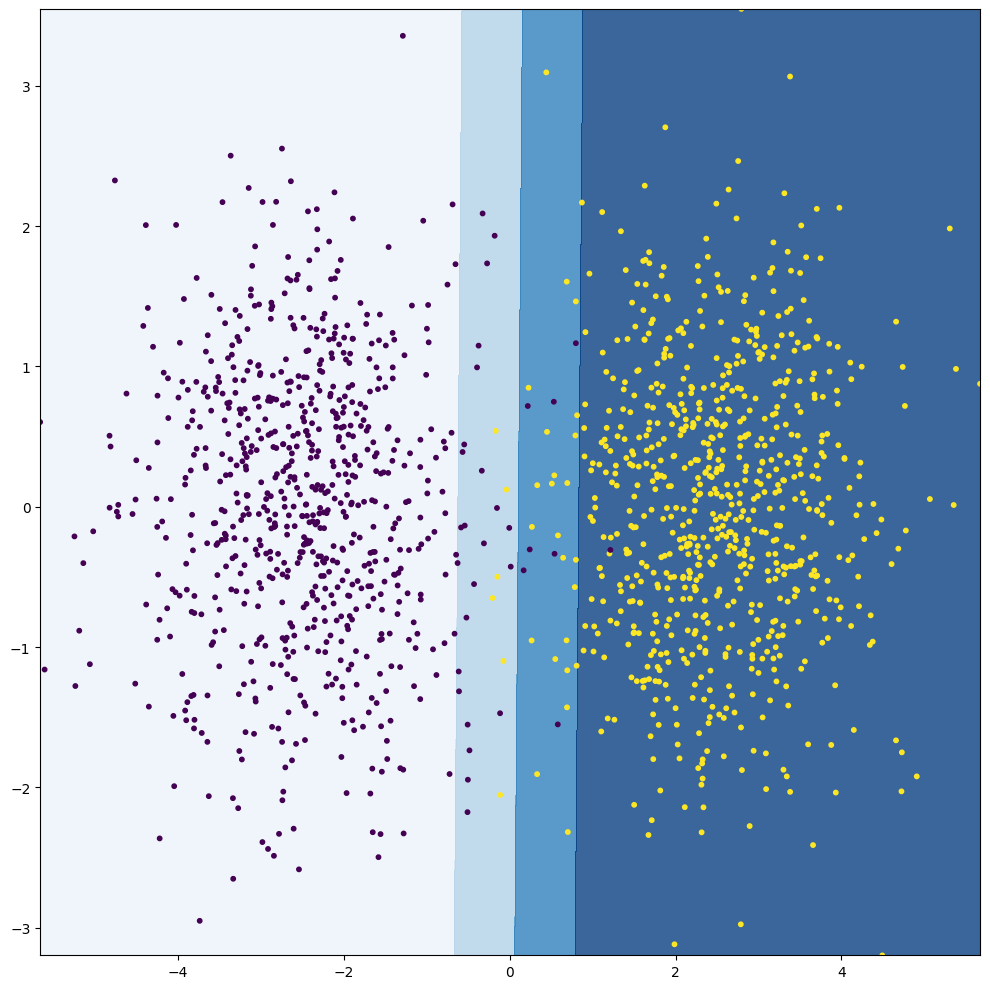

In [ ]:
u=np.arange(2.5,2.55,0.1)
testacc=linearSVM(u,1)

# Question 2.2.1
## Logistic Regression 

In [ ]:

class LogisticRegression(torch.nn.Module):
          def __init__(self, input_dim, output_dim):
              super(LogisticRegression, self).__init__()
              self.linear = torch.nn.Linear(input_dim, output_dim)
              
          def forward(self, x):
              outputs = torch.sigmoid(self.linear(x))
              return outputs

def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel("x_1") 
    plt.ylabel("x_2")
    plt.title(title)
    plt.show()


def logReg(u,plotTrue):
  testaccuracies=[]
  for i in range(len(u)):
      u0=np.array([u[i],0]).T
      u1=np.array([-u[i],0]).T
      print(u[i])
      covar0=[[1,0],[0,1]]
      covar1=[[1,0],[0,1]]
      # Generate gaussian
      red = multivariate_normal(u0,covar0,750)
      blue = multivariate_normal(u1,covar1,750)
      # Label them different
      red_labels = np.zeros(len(red))
      blue_labels = np.ones(len(blue))
      #Collect all labels together
      labels = np.append(red_labels,blue_labels)
      inputs = np.concatenate((red,blue),axis=0)
      #Split Training Test and Validation
      X_train, X_test, y_train,  y_test = train_test_split(inputs, labels, test_size=250, random_state=1)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

      
      #Declare hyperparameters
      epochs = 2000
      input_dim = 2 # Two inputs x1 and x2 
      output_dim = 1 # Two possible outputs
      learning_rate = 0.1
      #Declare Log regression class object
      model = LogisticRegression(input_dim,output_dim)

      criterion = torch.nn.BCELoss()

      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      #Convert to tensor
      X_train, X_test, X_val = torch.Tensor(X_train),torch.Tensor(X_test),torch.Tensor(X_val)
      y_train, y_test, y_val = torch.Tensor(y_train),torch.Tensor(y_test),torch.Tensor(y_val)
      #Start epochs
      losses = []
      losses_test = []
      Iterations = []
      iter = 0
      for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
          x = X_train
          labels = y_train
          optimizer.zero_grad() # Setting our stored gradients equal to zero
          outputs = model(X_train)
          loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
          
          loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
          
          optimizer.step() # Updates weights and biases with the optimizer (SGD)
          
          iter+=1
          if iter%1000==0:
              # calculate Accuracy
              with torch.no_grad():
                  # Calculating the loss and accuracy for the test dataset
                  correct_test = 0
                  total_test = 0
                  outputs_test = torch.squeeze(model(X_val))
                  loss_test = criterion(outputs_test, y_val)
                  
                  predicted_test = outputs_test.round().detach().numpy()
                  total_test += y_val.size(0)
                  correct_test += np.sum(predicted_test == y_val.detach().numpy())
                  accuracy_test = 100 * correct_test/total_test
                  losses_test.append(loss_test.item())
                  
                  # Calculating the loss and accuracy for the train dataset
                  total = 0
                  correct = 0
                  total += y_train.size(0)
                  correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                  accuracy = 100 * correct/total
                  losses.append(loss.item())
                  Iterations.append(iter)
                  
                  print(f"Iteration: {iter}. \nValidation - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                  print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

      with torch.no_grad():
          # Calculating the loss and accuracy for the test dataset
          correct_test = 0
          total_test = 0
          outputs_test = torch.squeeze(model(X_test))
          loss_test = criterion(outputs_test, y_test)
          
          predicted_test = outputs_test.round().detach().numpy()
          total_test += y_test.size(0)
          correct_test += np.sum(predicted_test == y_test.detach().numpy())
          accuracy_test = 100 * correct_test/total_test
          testaccuracies.append(accuracy_test)
          print(f"Test - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
      # Train Data
      if plotTrue:
        model_plot(model,X_train,y_train,'Logistic Regression')
  return testaccuracies

2.5


Training Epochs:  56%|█████▌    | 1118/2000 [00:01<00:01, 830.16it/s]

Iteration: 1000. 
Validation - Loss: 0.01828804984688759. Accuracy: 99.2
Train -  Loss: 0.020562103018164635. Accuracy: 99.4



Training Epochs: 100%|██████████| 2000/2000 [00:02<00:00, 799.04it/s]


Iteration: 2000. 
Validation - Loss: 0.016169235110282898. Accuracy: 99.2
Train -  Loss: 0.01805342175066471. Accuracy: 99.4

Test - Loss: 0.039568133652210236. Accuracy: 98.4


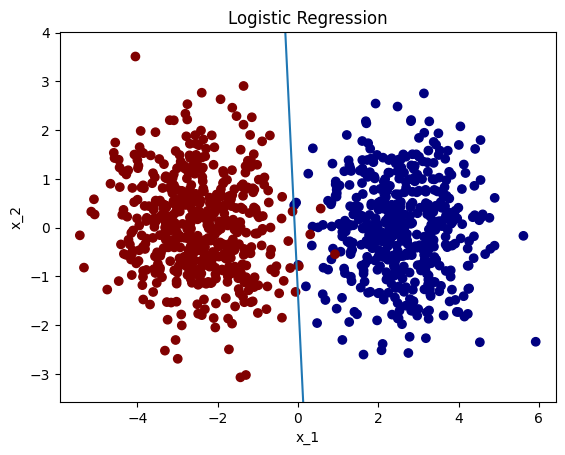

Test Accuracy: [98.4]


In [ ]:
u=np.arange(2.5,2.55,0.1)
testacc=logReg(u,1)
print("Test Accuracy:",testacc)

# Question 2.2.1
## KNN Classifier

In [ ]:
c=0.01
lr=0.1
batchsize=5
epoch=10
device="cuda"
h = .02  # step size in the mesh

# Create color maps
def KNNPred(u,plotTrue):
    device="cuda"
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    testaccuracies=[]
    for i in range(len(u)):

      u0=np.array([u[i],0]).T
      u1=np.array([-u[i],0]).T

      covar0=[[1,0],[0,1]]
      covar1=[[1,0],[0,1]]

      XP = multivariate_normal(u0,covar0,750)
      XN = multivariate_normal(u1,covar1,750)
      YP = np.ones(750)
      YN = np.empty(750)
      YN.fill(0)
      X , Y = np.concatenate((XP,XN)),np.hstack((YP,YN))
      X, Y = shuffle(X,Y,random_state=1)


      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=1)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

      error = []

      # Calculating MAE error for K values between 1 and 20
      for i in range(1, 20):
          knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
          knn.fit(X_train, y_train)
          pred_i = knn.predict(X_val)
          mae = mean_absolute_error(y_val, pred_i)
          error.append(mae)
     # print(error)
      best_k = np.argmin(error)+1
      print(best_k)
      clf = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
      clf.fit(X_train, y_train)    
      score = clf.score(X_test,y_test)
      print("Test accuracy: ",score)
      print(X_test.shape)
      testaccuracies.append(score*100)
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      if len(testaccuracies)==1:
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap="gray")

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="winter")
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
    return testaccuracies

1
Test accuracy:  0.9839907786885246
(250, 2)
Test accuracy: [98.39907786885246]


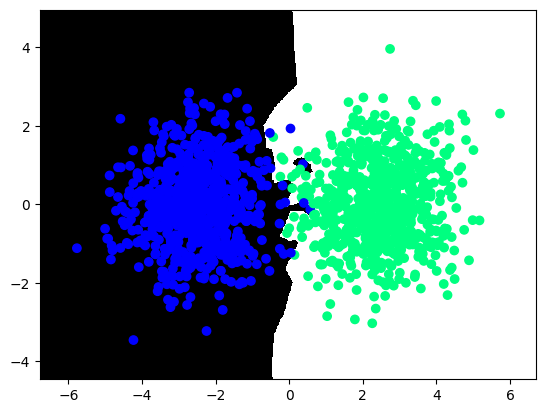

In [ ]:
u=np.arange(2.5,2.55,0.1)
testacc=KNNPred(u,1)
print("Test accuracy:",testacc)

# Question 2.2.1
## Naive Bayes Implementation

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [6]:
c=0.01
lr=0.1
batchsize=5
epoch=10
device="cuda"
def naiveb(u,plotTrue):
    device ='cuda'
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    testaccuracies=[]
    for i in range(len(u)):

      u0=np.array([u[i],0]).T
      u1=np.array([-u[i],0]).T

      covar0=[[1,0],[0,1]]
      covar1=[[1,0],[0,1]]

      XP = multivariate_normal(u0,covar0,750)
      XN = multivariate_normal(u1,covar1,750)
      YP = np.ones(750)
      YN = np.empty(750)
      YN.fill(0)
      X , Y = np.concatenate((XP,XN)),np.hstack((YP,YN))
      print(X.shape)
      print(Y.shape)
      X, Y = shuffle(X,Y,random_state=1)


      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=1)
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

      nb = GaussianNB()
      params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
      gs_NB = GridSearchCV(estimator=nb, 
                 param_grid=params_NB, 
                 cv=10,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
      gs_NB.fit(X_train, y_train)
      print(gs_NB.best_params_)
      score = gs_NB.score(X_test,y_test)
      print("Test accuracy: ",score)
      testaccuracies.append(score*100)
      xlim = (X[:, 0].min(), X[:, 0].max())
      ylim = (X[:, 1].min(), X[:, 1].max())
      delta = 0.001
      xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], delta), np.arange(ylim[0], ylim[1], delta))
      Z = gs_NB.predict_proba(np.c_[xx.ravel(), yy.ravel()])
      Z = Z[:, 1].reshape(xx.shape)

      #------------------------------------------------------------
      # Plot the results
      if plotTrue:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.scatter(X[:, 0], X[:, 1], c=Y,s=10)

        ax.contour(xx, yy, Z, [0.5], colors='k')

        ax.set_xlim(xlim[0]+delta,xlim[1]-delta)
        ax.set_ylim(ylim[0]+delta,xlim[1]-delta)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

      plt.show()
    return testaccuracies



(1500, 2)
(1500,)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'var_smoothing': 0.533669923120631}
Test accuracy:  0.996


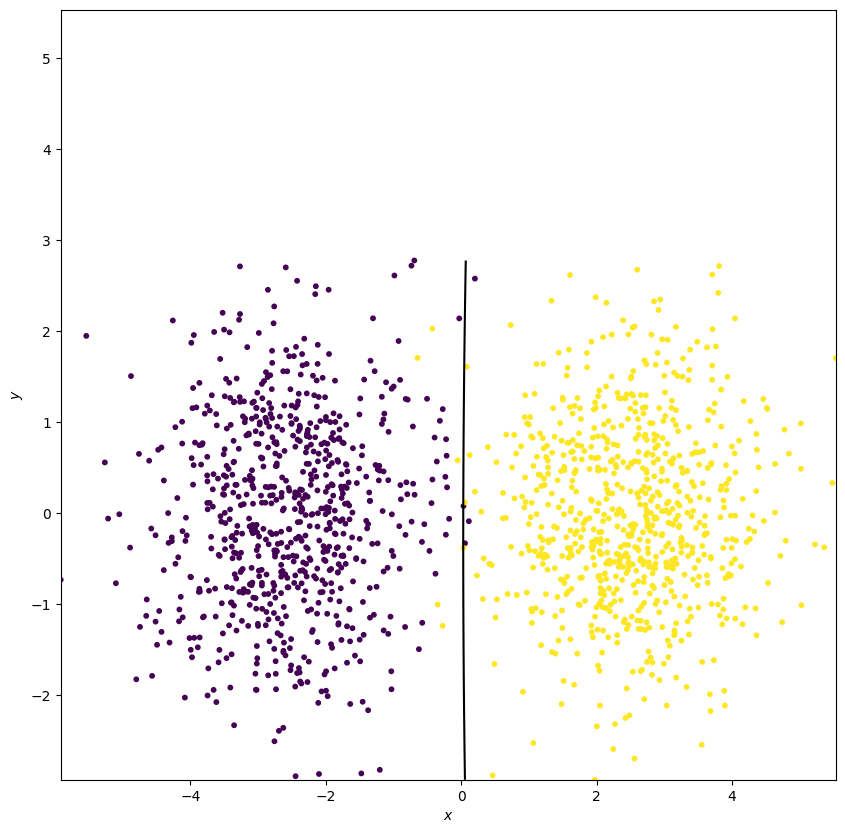

Test Accuracy: [99.6]


In [7]:
u=np.arange(2.5,2.55,0.1)
testacc=naiveb(u,1)
print("Test Accuracy:",testacc)

# Question 2.2.1
## Repeating for μ = 1.0 to 2.4 in increments of 0.2

1
Epoch:    1	Training loss: 0.08291311567998491
Validation accuracy:  0.832
Epoch:    2	Training loss: 0.08091874910704791
Validation accuracy:  0.832
Epoch:    3	Training loss: 0.08099703055713325
Validation accuracy:  0.832
Epoch:    4	Training loss: 0.08067057472746819
Validation accuracy:  0.828
Epoch:    5	Training loss: 0.08107941186707467
Validation accuracy:  0.832
Epoch:    6	Training loss: 0.08055825102515518
Validation accuracy:  0.836
Epoch:    7	Training loss: 0.08084171766601503
Validation accuracy:  0.832
Epoch:    8	Training loss: 0.08079896025452762
Validation accuracy:  0.828
Epoch:    9	Training loss: 0.08058062883652747
Validation accuracy:  0.832
Epoch:   10	Training loss: 0.08085923675820231
Validation accuracy:  0.832
Test accuracy:  0.82
1.2
Epoch:    1	Training loss: 0.06702630832698196
Validation accuracy:  0.9
Epoch:    2	Training loss: 0.05989620802085847
Validation accuracy:  0.896
Epoch:    3	Training loss: 0.05922317653987557
Validation accuracy:  0.904


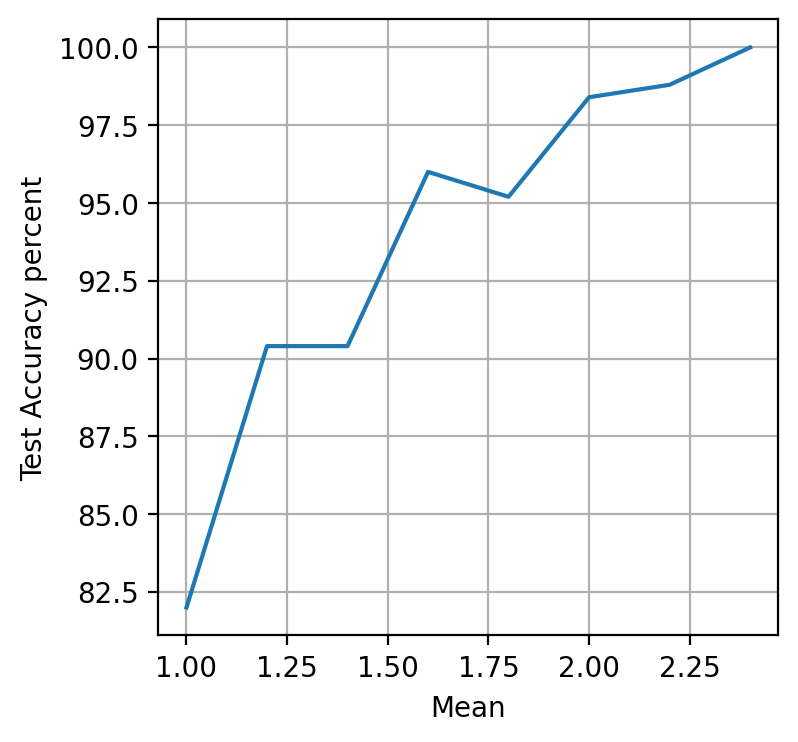

In [ ]:
u2=[1,1.2,1.4,1.6,1.8,2.0,2.2,2.4]
testacc=linearSVM(u2,0)
accPrint(u2,testacc)

1


Training Epochs:  64%|██████▍   | 1288/2000 [00:00<00:00, 1416.31it/s]

Iteration: 1000. 
Validation - Loss: 0.32638630270957947. Accuracy: 85.6
Train -  Loss: 0.34895801544189453. Accuracy: 85.8



Training Epochs: 100%|██████████| 2000/2000 [00:01<00:00, 1374.71it/s]


Iteration: 2000. 
Validation - Loss: 0.32637831568717957. Accuracy: 85.6
Train -  Loss: 0.34895795583724976. Accuracy: 85.8

Test - Loss: 0.3269074559211731. Accuracy: 85.2
1.2


Training Epochs:  60%|█████▉    | 1197/2000 [00:00<00:00, 1288.45it/s]

Iteration: 1000. 
Validation - Loss: 0.26353320479393005. Accuracy: 87.2
Train -  Loss: 0.2504009008407593. Accuracy: 87.8



Training Epochs: 100%|██████████| 2000/2000 [00:01<00:00, 1331.84it/s]


Iteration: 2000. 
Validation - Loss: 0.2637050151824951. Accuracy: 87.2
Train -  Loss: 0.2503874897956848. Accuracy: 87.8

Test - Loss: 0.29117995500564575. Accuracy: 85.6
1.4


Training Epochs:  59%|█████▉    | 1186/2000 [00:00<00:00, 1270.60it/s]

Iteration: 1000. 
Validation - Loss: 0.19859740138053894. Accuracy: 90.8
Train -  Loss: 0.17739950120449066. Accuracy: 92.4



Training Epochs: 100%|██████████| 2000/2000 [00:01<00:00, 1629.90it/s]


Iteration: 2000. 
Validation - Loss: 0.19913539290428162. Accuracy: 90.8
Train -  Loss: 0.1772957295179367. Accuracy: 92.4

Test - Loss: 0.2657625079154968. Accuracy: 88.0
1.6


Training Epochs:  66%|██████▌   | 1310/2000 [00:00<00:00, 2494.29it/s]

Iteration: 1000. 
Validation - Loss: 0.16112956404685974. Accuracy: 93.2
Train -  Loss: 0.1503189206123352. Accuracy: 94.2



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2550.17it/s]


Iteration: 2000. 
Validation - Loss: 0.162485271692276. Accuracy: 93.2
Train -  Loss: 0.1501826047897339. Accuracy: 94.3

Test - Loss: 0.1437913328409195. Accuracy: 95.2
1.8


Training Epochs:  67%|██████▋   | 1331/2000 [00:00<00:00, 2593.73it/s]

Iteration: 1000. 
Validation - Loss: 0.07717414200305939. Accuracy: 96.4
Train -  Loss: 0.11039983481168747. Accuracy: 95.6



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2632.24it/s]


Iteration: 2000. 
Validation - Loss: 0.07528515160083771. Accuracy: 96.4
Train -  Loss: 0.11008509248495102. Accuracy: 95.4

Test - Loss: 0.08124364912509918. Accuracy: 98.0
2.0


Training Epochs:  69%|██████▉   | 1381/2000 [00:00<00:00, 2622.28it/s]

Iteration: 1000. 
Validation - Loss: 0.1356174200773239. Accuracy: 94.0
Train -  Loss: 0.050467781722545624. Accuracy: 98.4



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2634.29it/s]


Iteration: 2000. 
Validation - Loss: 0.14261110126972198. Accuracy: 94.4
Train -  Loss: 0.04769665375351906. Accuracy: 98.3

Test - Loss: 0.04495241865515709. Accuracy: 98.4
2.2


Training Epochs:  68%|██████▊   | 1350/2000 [00:00<00:00, 2582.24it/s]

Iteration: 1000. 
Validation - Loss: 0.04483833536505699. Accuracy: 98.8
Train -  Loss: 0.028279658406972885. Accuracy: 99.4



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2571.35it/s]


Iteration: 2000. 
Validation - Loss: 0.04401879385113716. Accuracy: 98.8
Train -  Loss: 0.02396402508020401. Accuracy: 99.3

Test - Loss: 0.0549372062087059. Accuracy: 98.8
2.4


Training Epochs:  67%|██████▋   | 1334/2000 [00:00<00:00, 2640.50it/s]

Iteration: 1000. 
Validation - Loss: 0.025034500285983086. Accuracy: 99.2
Train -  Loss: 0.026819171383976936. Accuracy: 99.2



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2616.02it/s]


Iteration: 2000. 
Validation - Loss: 0.019756712019443512. Accuracy: 99.2
Train -  Loss: 0.023087870329618454. Accuracy: 99.3

Test - Loss: 0.034902457147836685. Accuracy: 97.6


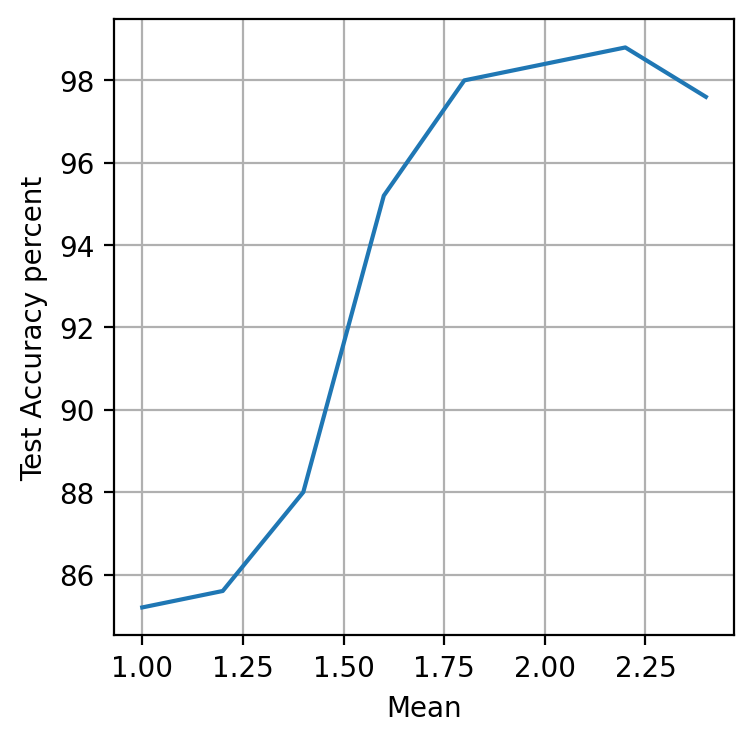

In [ ]:
u2=[1,1.2,1.4,1.6,1.8,2.0,2.2,2.4]
testacc=logReg(u2,0)
accPrint(u2,testacc)

4
Test accuracy:  0.44225768901719464
(250, 2)
1
Test accuracy:  0.3596311475409836
(250, 2)
3
Test accuracy:  0.6761409187785042
(250, 2)
19
Test accuracy:  0.8274670586535686
(250, 2)
2
Test accuracy:  0.8259793641937686
(250, 2)
1
Test accuracy:  0.9359631147540983
(250, 2)
1
Test accuracy:  0.9199538934426229
(250, 2)
6
Test accuracy:  0.9519736569964966
(250, 2)


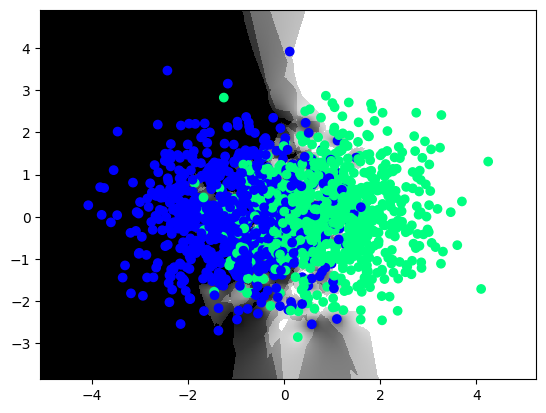

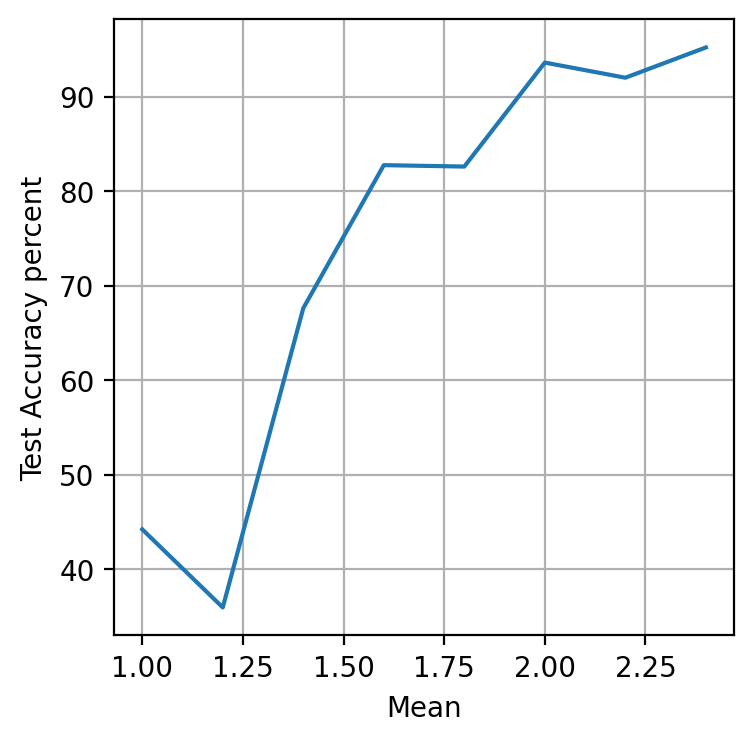

In [ ]:
testacc=KNNPred(u2,0)
accPrint(u2,testacc)

In [ ]:
u2=[1,1.2,1.4,1.6,1.8,2.0,2.2,2.4]
testacc=naiveb(u2,0)

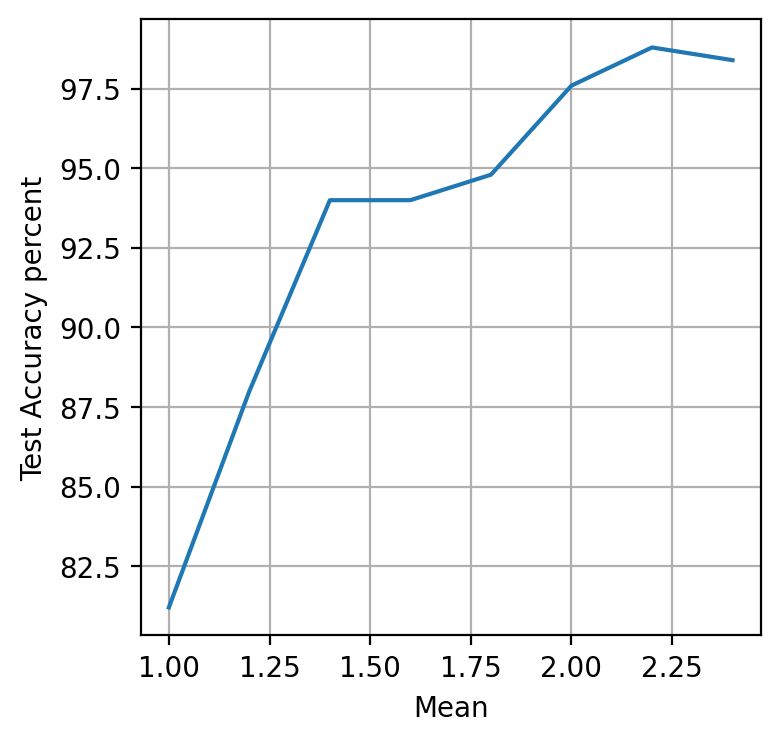

In [ ]:
accPrint(u2,testacc)